# Imports

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
import ast
import albumentations as A
from tqdm import tqdm

# Organize Folders and Filenames

In [2]:
# path_test = './images/Sign_Language_Letter_Request/'
# path_labels = './labels/'

In [3]:
# # Do this first before manual labeling
# # Do not run more than once!

# for folder in os.listdir(path_test):
#     for count, filename in enumerate(os.listdir(path_test+'/'+folder)):
#         dst = folder + str(count) + '.jpg'
#         src = path_test+ folder +'/'+ filename 
#         dst = path_test+ folder +'/'+ dst 
#         os.rename(src, dst)

In [4]:
# The above cell changed the file names in all of my letter folders from this:

![](./assets/unorganized_file_structure.png)

In [5]:
# To this:

![](./assets/organized_file_structure.png)

# Labeling and bounding boxes

### Manually label images using labelImg. When all original images are labeled, proceed to the next step
### https://github.com/tzutalin/labelImg

# Load Images

In [6]:
image = cv2.imread('./images/Sign_Language_Letter_Request/O/O4.jpg')


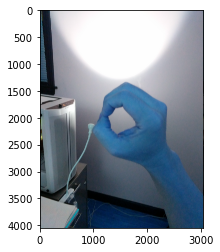

In [7]:
plt.imshow(image)

In [8]:
image.shape

(4048, 3036, 3)

In [9]:
load_bboxes = np.genfromtxt('./labels/O4.txt')
load_bboxes = list(load_bboxes)
bbox_cat = int(load_bboxes[0])
bboxes = load_bboxes[1:]
bboxes

[0.551713, 0.519392, 0.490777, 0.404397]

In [10]:
bbox_cat

14

In [11]:
load_bboxes

[14.0, 0.551713, 0.519392, 0.490777, 0.404397]

In [12]:
img_ht = int(image.shape[0])
img_wd = int(image.shape[1])
bb_width = int(round(bboxes[2] * image.shape[1], 0))
bb_height = int(round(bboxes[3] * image.shape[0], 0))

print(f'Image height: {img_ht}')
print(f'Image width: {img_wd}')
print(f'Bbox height: {bb_height}')
print(f'Bbox width: {bb_width}')

Image height: 4048
Image width: 3036
Bbox height: 1637
Bbox width: 1490


In [13]:
# pascal_voc format 
x_min = int((img_wd * bboxes[0]) - (bb_width/2))
x_max = int((img_wd * bboxes[0]) + (bb_width/2))
y_min = int(img_ht * bboxes[1] - (bb_height/2))
y_max = int(img_ht * bboxes[1] + (bb_height/2))
new_bboxes = [x_min, y_min, x_max, y_max]
print(f'Bbox x_min: {x_min}')
print(f'Bbox x_max: {x_max}')
print(f'Bbox y_min: {y_min}')
print(f'Bbox y_max: {y_max}')
print(f'new_bboxes: {new_bboxes}')

Bbox x_min: 930
Bbox x_max: 2420
Bbox y_min: 1283
Bbox y_max: 2920
new_bboxes: [930, 1283, 2420, 2920]


# Show image and Bounding Box Function

In [14]:
# Inspired by Venelin Valkov
# Source: https://www.curiousily.com/posts/image-data-augmentation-for-tensorflow-2-keras-and-pytorch-with-albumentations-in-python/
category_id_to_name = {0: 'A', 
                       1: 'B',
                       2: 'C', 
                       3: 'D',
                       4: 'E', 
                       5: 'F',
                       6: 'G', 
                       7: 'H',
                       8: 'I', 
                       9: 'J',
                       10: 'K',
                       11: 'L',
                       12: 'M',
                       13: 'N',
                       14: 'O',
                       15: 'P',
                       16: 'Q',
                       17: 'R',
                       18: 'S',
                       19: 'T',
                       20: 'U',
                       21: 'V',
                       22: 'W',
                       23: 'X',
                       24: 'Y',
                       25: 'Z',
                       }
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255) # White

def show_image(image, bbox, bbox_cat, category_id_to_name):
    class_name = category_id_to_name[bbox_cat]
    image = visualize_bbox(image.copy(), bbox, class_name)
    f = plt.figure(figsize=(10,10))
    plt.imshow(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        interpolation='nearest'
    )
    plt.axis('off')
    f.tight_layout()
    plt.show()
    
def visualize_bbox(image, bbox, class_name, color=BOX_COLOR, thickness=4):
    x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
    
    cv2.rectangle(
        image,
        (x_min, y_min),
        (x_max, y_max),
        color=color,
        thickness=thickness
    )
        
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2.7, 3)    
    cv2.rectangle(image, (x_min, y_min - int(1.2 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        image,
#         text=class_name,
        text= category_id_to_name[bbox_cat],
        org=(x_min, y_min - int(.1 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=2.35, 
        color=TEXT_COLOR,
        thickness=3,
        lineType=cv2.LINE_AA,
    )
    return image



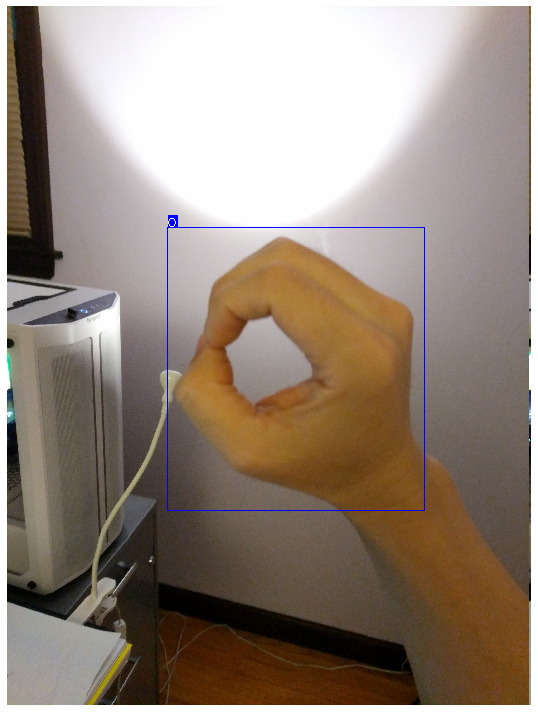

In [15]:
show_image(image, new_bboxes, bbox_cat, category_id_to_name)

In [16]:
def show_augmented(augmentation, image, bbox, class_name):
    augmented = augmentation(image=image, bboxes=[bbox], class_name=[class_name])
    show_image(augmented['image'], augmented['bboxes'][0], bbox_cat, category_id_to_name)

In [17]:
# [x_min, y_min, x_max, y_max]
bbox_params = A.BboxParams(
    format= 'pascal_voc',
    min_area=1,
    min_visibility=0.5,
    label_fields=['class_name']
)

In [18]:
# Source: https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example_bboxes.ipynb
aug = A.Compose([
    A.LongestMaxSize(max_size=1024),
    A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0,p=1.0),
    A.ShiftScaleRotate(shift_limit=.25, scale_limit=0.2, p=0.3),
    A.RandomSizedCrop((900, 1000), 1024, 1024, p=.2),
    A.HorizontalFlip(p=.5),
    A.Rotate(limit=30,p=.8),
    A.MultiplicativeNoise(p=.2),
    A.RGBShift(r_shift_limit=40, g_shift_limit=40, b_shift_limit=40, p=.3),
    A.Blur(blur_limit=25, p=.2),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.35,p=.5),
    A.HueSaturationValue(p=.3),
    A.CoarseDropout(max_holes=9,min_width=30, max_width=250, min_height=30, max_height=250,p=.2),
    A.OneOf([A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(var_limit=(10, 50),mean=50)], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1)], p=0.2),
    A.OneOf([
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast(),
        A.RandomGamma(gamma_limit=[50,200], p=.2),
        A.ToGray()], p=0.3),
        A.NoOp(p=.04)
]
    , bbox_params=bbox_params)


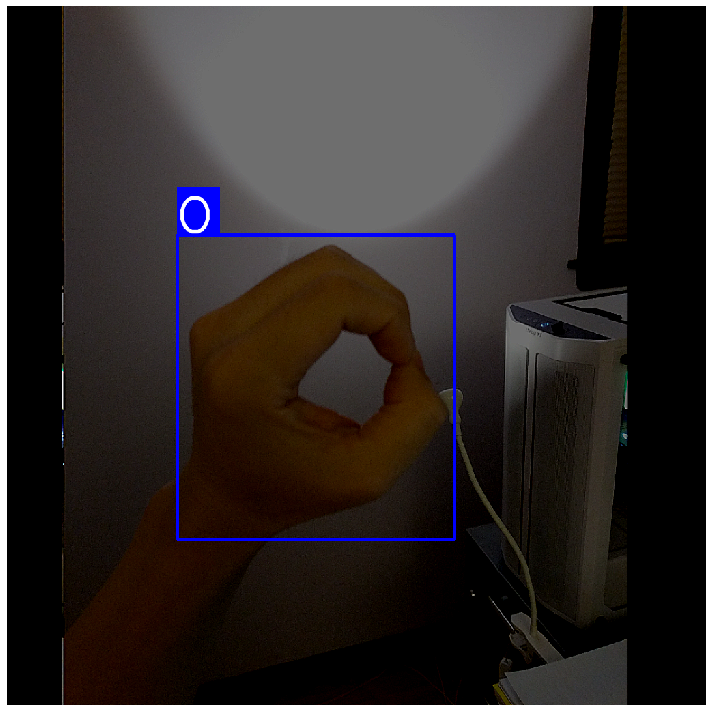

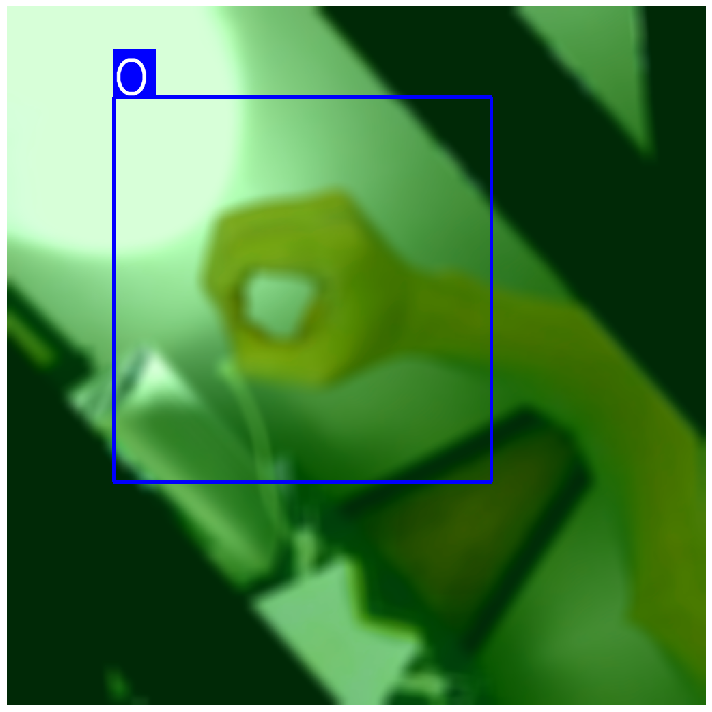

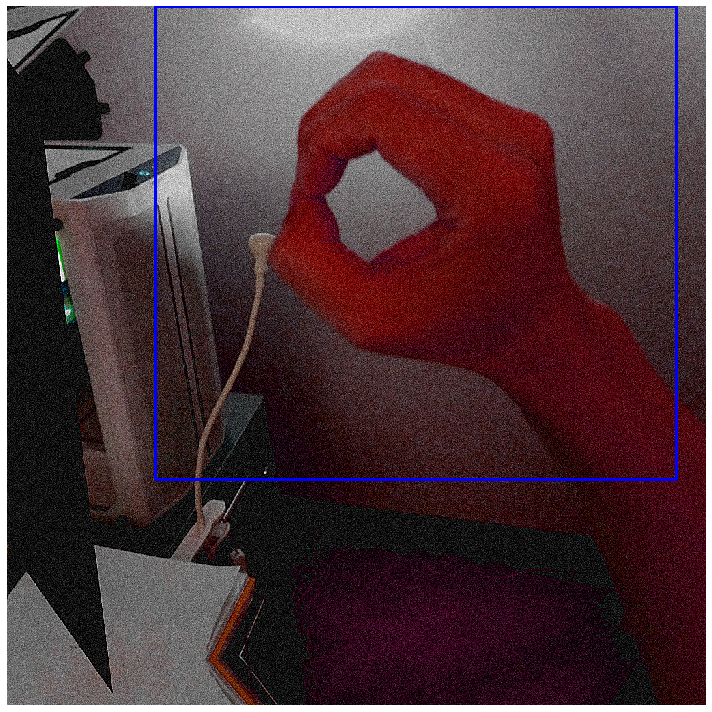

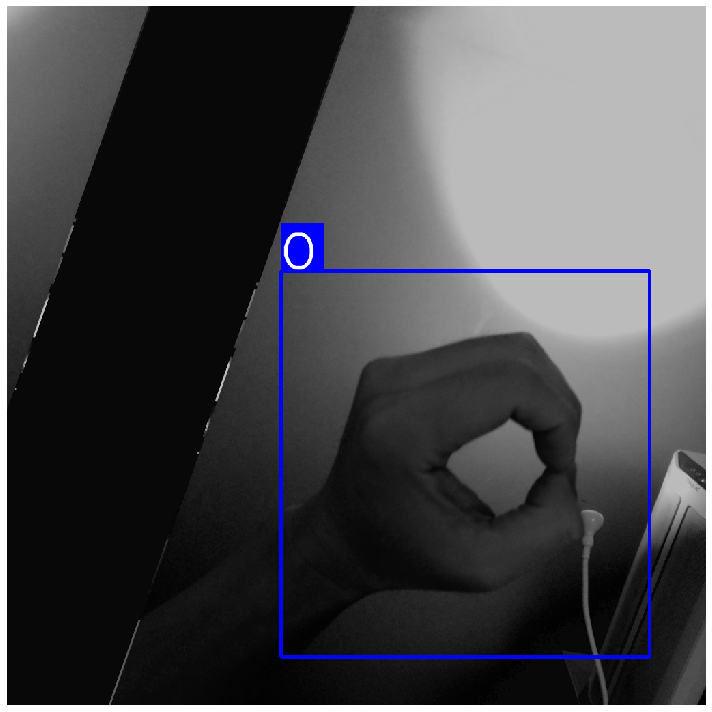

In [19]:
for i in range(4):
    show_augmented(aug, image, new_bboxes, category_id_to_name)

# Creating Augmented Dataset


In [20]:
path_sign_language_letter_request = './images/Sign_Language_Letter_Request/'
path_labels = './labels/'
DATASET_PATH = 'asl_modeling_data/aug_data'
IMAGES_PATH = f'{DATASET_PATH}/images'
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(IMAGES_PATH, exist_ok=True)

rows = []

for folder in os.listdir(path_sign_language_letter_request):
    for count, filename in enumerate(os.listdir(path_sign_language_letter_request+'/'+folder)):
        image = cv2.imread(path_sign_language_letter_request + folder +'/' + filename)
        load_bboxes = np.genfromtxt(path_labels+filename[:-4] + '.txt')
        load_bboxes = list(load_bboxes)
        bbox_cat = int(load_bboxes[0])
        bboxes = load_bboxes[1:]
        img_ht = int(image.shape[0])
        img_wd = int(image.shape[1])
        bb_width = int(round(bboxes[2] * image.shape[1], 0))
        bb_height = int(round(bboxes[3] * image.shape[0], 0))

        x_min = int((img_wd * bboxes[0]) - (bb_width/2))
        x_max = int((img_wd * bboxes[0]) + (bb_width/2))
        y_min = int(img_ht * bboxes[1] - (bb_height/2))
        y_max = int(img_ht * bboxes[1] + (bb_height/2))
        new_bboxes = [x_min, y_min, x_max, y_max]


        
        for i in range(25):
            class_name = bbox_cat
            augmented = aug(image=image, bboxes=[new_bboxes], class_name=[bbox_cat])
            file_name = f'{filename[:-4]}_{i}.jpg'
            for bbox in augmented['bboxes']:
                x_min, y_min, x_max, y_max = map(lambda v: int(v), bbox)
                
                # Converting back to Yolo format
                x_center = (x_min + x_max) / 2
                x_center /= 1024
                y_center = (y_min + y_max) / 2
                y_center /= 1024
                w = (x_max - x_min) / 1024
                h = (y_max - y_min) /1024
                new_bbox = [bbox_cat, x_center, y_center, w, h]
                
                rows.append({
                    'image_id': f'images/{file_name}',
                    'bbox': new_bbox
                })
            cv2.imwrite(f'{IMAGES_PATH}/{file_name}', augmented['image'])
pd.DataFrame(rows).to_csv(f'{DATASET_PATH}/annotations.csv', header=True, index=None)

# Verify augmented images and bounding boxes match

In [30]:
image = cv2.imread('./asl_modeling_data/aug_data/images/T10_0.jpg')

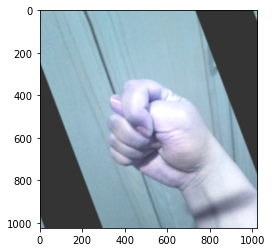

In [32]:
plt.imshow(image)

In [33]:
image.shape

(1024, 1024, 3)

In [35]:
df = pd.read_csv('./asl_modeling_data/aug_data/annotations.csv')
df.head()

image_id                                               bbox
0  images/T10_0.jpg  [19, 0.54736328125, 0.56201171875, 0.688476562...
1  images/T10_1.jpg  [19, 0.39453125, 0.6552734375, 0.7890625, 0.68...
2  images/T10_2.jpg  [19, 0.51416015625, 0.5771484375, 0.5732421875...
3  images/T10_3.jpg  [19, 0.48876953125, 0.4521484375, 0.9775390625...
4  images/T10_4.jpg  [19, 0.49072265625, 0.578125, 0.7021484375, 0....

In [63]:
# Convert string to list
df.bbox = df.bbox.apply(ast.literal_eval)

In [68]:
new_bboxes = df['bbox'][0][1:]

In [69]:
new_bboxes

[0.54736328125, 0.56201171875, 0.6884765625, 0.7216796875]

In [71]:
bbox_cat = df['bbox'][0][0]
bbox_cat

19

In [72]:

x_min = int((1024 * new_bboxes[0]) - ((new_bboxes[2]*1024)/2))
x_max = int((1024 * new_bboxes[0]) + ((new_bboxes[2]*1024)/2))
y_min = int(1024 * new_bboxes[1] - ((new_bboxes[3]*1024)/2))
y_max = int(1024 * new_bboxes[1] + ((new_bboxes[3]*1024)/2))
new_bboxes = [x_min, y_min, x_max, y_max]

In [73]:
new_bboxes

[208, 206, 913, 945]

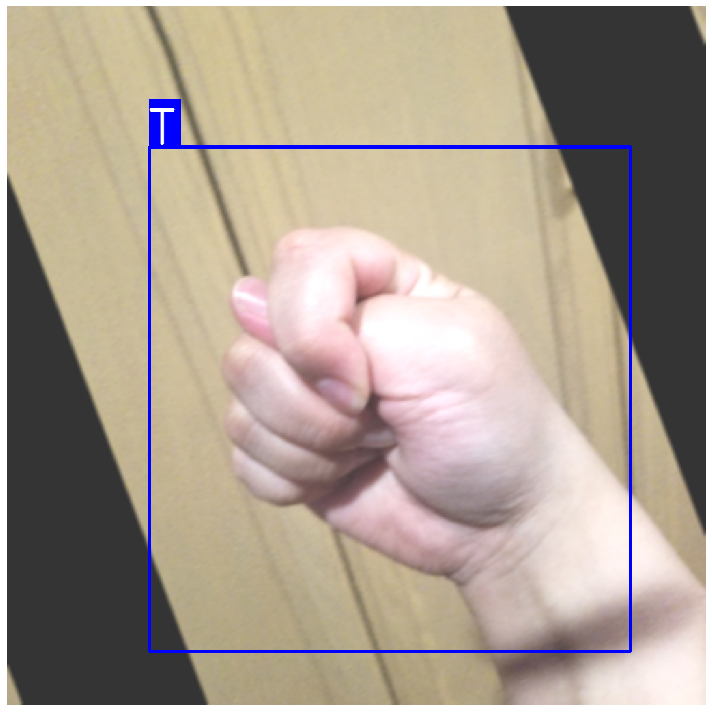

In [74]:
show_image(image, new_bboxes, bbox_cat, category_id_to_name)